# Detection with CNNClassifier: Baseline Model


In [1]:
from dotenv import load_dotenv

load_dotenv()

import sys
import os

sys.path.append(os.getenv('SRC_DIR'))

from utils.system import display_system_info

display_system_info(markdown=True)


**Last Updated**: 2025-04-28 14:12:33

**Python Version**: 3.11.8  
**OS**: Windows 10.0.26100  
**Architecture**: 64bit  
**Hostname**: Gan  
**Processor**: Intel64 Family 6 Model 186 Stepping 3, GenuineIntel  
**RAM Size**: 15.65 GB  
  
        

In [2]:
from torchvision import transforms
import torch
import cv2
from PIL import Image
import numpy as np

from classify import TorchClassifier

In [3]:
IDX_TO_CLASS = {
    0: 'swimming',
    1: 'treadwater',
    2: 'drowning'
}

def xywhn_to_xyxy(image, x_n, y_n, w_n, h_n):
    # cv2 images in HWC
    height, width, _ = image.shape

    x1 = int((x_n - w_n / 2) * width)
    y1 = int((y_n - h_n / 2) * height)
    x2 = int((x_n + w_n / 2) * width)
    y2 = int((y_n + h_n / 2) * height)

    return x1, y1, x2, y2

def cop_save_roi(images_folder, labels_folder, output_folder, idx_to_class):
    os.makedirs(output_folder, exist_ok=True)
    for class_id, class_name in idx_to_class.items():
        os.makedirs(os.path.join(output_folder, class_name), exist_ok=True)
        
    class_counters = {class_id: 0 for class_id in idx_to_class.keys()}

    for image_file in os.listdir(images_folder):
        if image_file.endswith('.jpg'):
            base_name = os.path.splitext(image_file)[0]
            
            label_file = os.path.join(labels_folder, f"{base_name}.txt")
            image_path = os.path.join(images_folder, image_file)
            
            image = cv2.imread(image_path)
            
            # Read the label file
            with open(label_file, 'r') as file:
                lines = file.readlines()
            
            # Loop through each line in the label file
            for line in lines:
                values = line.strip().split()
                class_id = int(values[0])
                x_n, y_n, w_n, h_n = map(float, values[1:])

                x1, y1, x2, y2 = xywhn_to_xyxy(image, x_n, y_n, w_n, h_n)

                roi = image[y1:y2, x1:x2]

                cv2.imwrite(os.path.join(output_folder, idx_to_class[class_id], f"{str(class_counters[class_id]).zfill(6)}.jpg"), roi)

                class_counters[class_id] += 1

In [ ]:
for split in ['train', 'val']:
    images_folder = os.path.join(os.getenv('RAW_DATA_DIR'), 'images', split)
    labels_folder = os.path.join(os.getenv('RAW_DATA_DIR'), 'labels', split)
    output_folder = os.path.join(os.getenv('ROI_DATA_DIR'), split)

    cop_save_roi(images_folder, labels_folder, output_folder, IDX_TO_CLASS)

In [4]:
model_config = {
    'num_classes': 3,
    'num_blocks': 4,
    'first_out_channel': 32,
    'out_channel_multiplier': 2,
    'kernel_size': 3,
    'stride': 1,
    'padding': 1,
    'input_shape': (3, 128, 128)
}

model = TorchClassifier(model='CNNClassifier', config=model_config, device='auto', verbose=False)

In [5]:
enhance_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [6]:
results = model.train(
    data_path=os.getenv('ROI_DATA_DIR'),
    imbalance=False,
    fraction=1,
    val_test_ratio=0.5,
    input_size=128,
    optimizer='Adam',
    lr=1e-4,
    enhance_transform=enhance_transform,
    val_transform=val_transform,
    batch_size=32,
    epochs=5
) 

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        1/5     0.3331      88.07     0.8598     0.8411     0.8498     0.8801     0.8816     0.8804: 100%|██████████| 320/320 [03:45<00:00,  1.42it/s]


                  Loss


                0.1165: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]


              precision    recall  f1-score   support

    drowning     0.9330    0.9176    0.9252       182
    swimming     0.9812    0.9855    0.9834       690
  treadwater     0.9298    0.9298    0.9298       285

    accuracy                         0.9611      1157
   macro avg     0.9480    0.9443    0.9461      1157
weighted avg     0.9610    0.9611    0.9610      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        2/5     0.1723       94.2     0.9277     0.9232     0.9254     0.9427     0.9429     0.9428: 100%|██████████| 320/320 [06:22<00:00,  1.20s/it]


                  Loss


                0.1046: 100%|██████████| 37/37 [00:09<00:00,  4.11it/s]


              precision    recall  f1-score   support

    drowning     0.9067    0.9615    0.9333       182
    swimming     0.9898    0.9812    0.9854       690
  treadwater     0.9429    0.9263    0.9345       285

    accuracy                         0.9646      1157
   macro avg     0.9465    0.9563    0.9511      1157
weighted avg     0.9652    0.9646    0.9647      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        3/5       0.13      95.61     0.9449     0.9421     0.9434      0.957      0.957      0.957: 100%|██████████| 320/320 [04:48<00:00,  1.11it/s]


                  Loss


               0.07753: 100%|██████████| 37/37 [00:34<00:00,  1.08it/s]


              precision    recall  f1-score   support

    drowning     0.9500    0.9396    0.9448       182
    swimming     0.9870    0.9884    0.9877       690
  treadwater     0.9476    0.9509    0.9492       285

    accuracy                         0.9715      1157
   macro avg     0.9615    0.9596    0.9606      1157
weighted avg     0.9714    0.9715    0.9715      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        4/5     0.1171      96.11     0.9516     0.9493     0.9504     0.9621     0.9621     0.9621: 100%|██████████| 320/320 [09:37<00:00,  1.81s/it]


                  Loss


               0.07571: 100%|██████████| 37/37 [00:07<00:00,  4.72it/s]


              precision    recall  f1-score   support

    drowning     0.9351    0.9505    0.9428       182
    swimming     0.9898    0.9884    0.9891       690
  treadwater     0.9541    0.9474    0.9507       285

    accuracy                         0.9723      1157
   macro avg     0.9597    0.9621    0.9609      1157
weighted avg     0.9724    0.9723    0.9724      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        5/5     0.1098      96.43     0.9554     0.9534     0.9544     0.9653     0.9652     0.9652: 100%|██████████| 320/320 [03:23<00:00,  1.58it/s]


                  Loss


               0.07339: 100%|██████████| 37/37 [00:08<00:00,  4.29it/s]

              precision    recall  f1-score   support

    drowning     0.9448    0.9396    0.9421       182
    swimming     0.9884    0.9899    0.9891       690
  treadwater     0.9509    0.9509    0.9509       285

    accuracy                         0.9723      1157
   macro avg     0.9614    0.9601    0.9607      1157
weighted avg     0.9723    0.9723    0.9723      1157



In [7]:
results

([{'loss': 0.3324128907523118,
   'accuracy': 88.09058961343226,
   'macro_f1': 0.8500357511679407,
   'weighted_f1': 0.8806574588328671,
   'macro_precision': 0.8599561058830888,
   'weighted_precision': 0.8803367161434053,
   'macro_recall': 0.8414370319902044,
   'weighted_recall': 0.8817666601524331},
  {'loss': 0.1717984601506032,
   'accuracy': 94.2112456071847,
   'macro_f1': 0.925580112677551,
   'weighted_f1': 0.9429320122803928,
   'macro_precision': 0.9278452943496837,
   'weighted_precision': 0.9428839499752754,
   'macro_recall': 0.9234155362510587,
   'weighted_recall': 0.9430330271643541},
  {'loss': 0.12970150092733093,
   'accuracy': 95.61694650527137,
   'macro_f1': 0.9436112132678254,
   'weighted_f1': 0.9570865825897396,
   'macro_precision': 0.9450790492593395,
   'weighted_precision': 0.9571274278566883,
   'macro_recall': 0.94224723661043,
   'weighted_recall': 0.9571037717412546},
  {'loss': 0.11718988427310251,
   'accuracy': 96.11479890667708,
   'macro_f1': 0

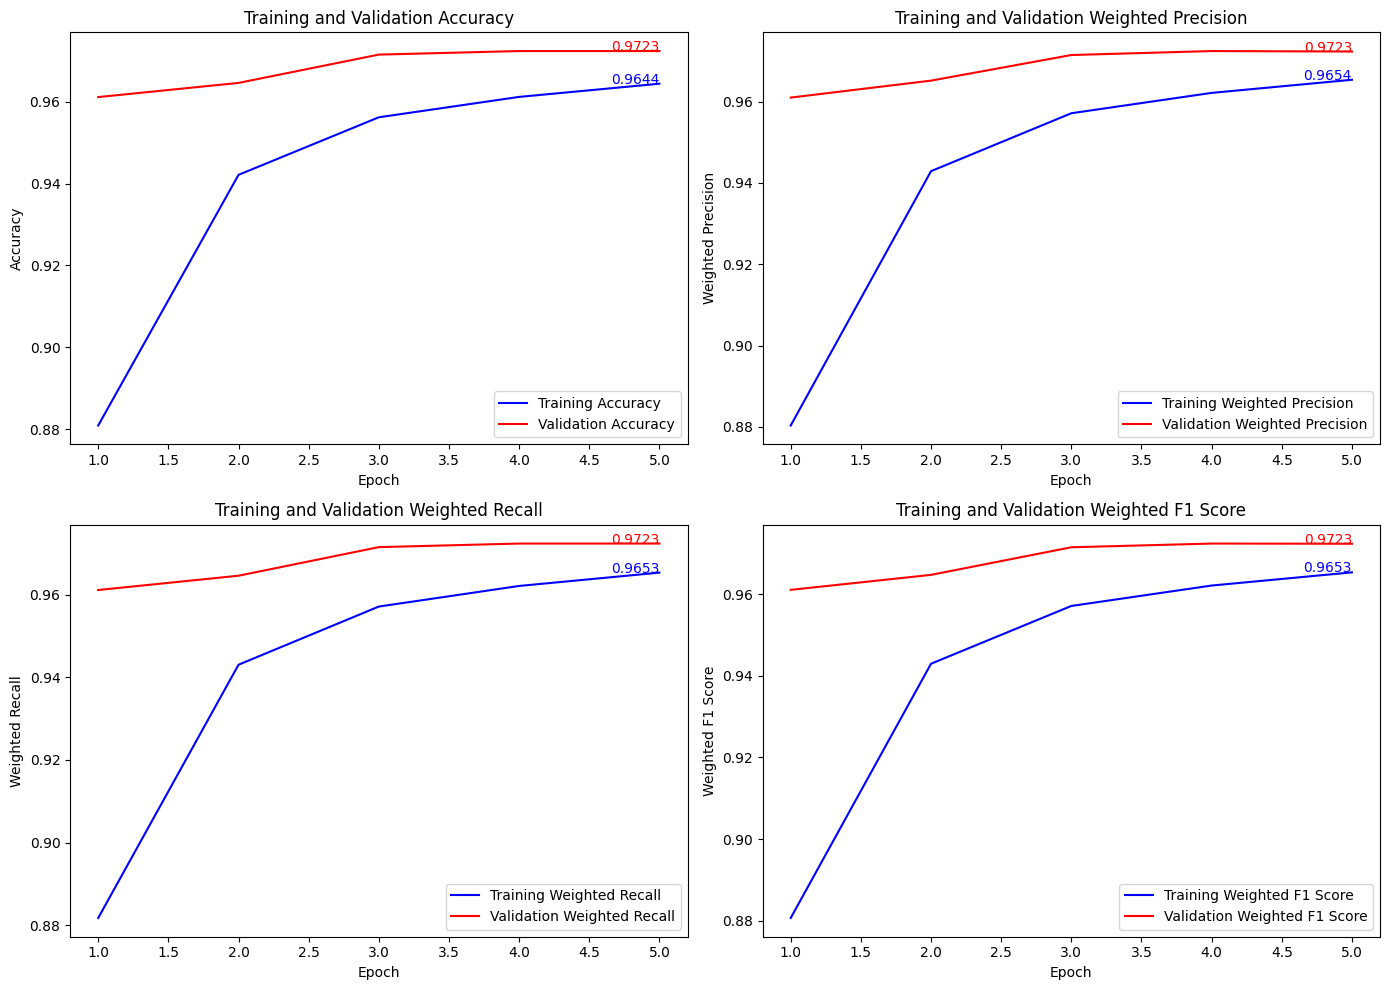

In [10]:
import matplotlib.pyplot as plt

# Split results into training and validation metrics
train_metrics, validation_metrics = results

# Extract training metrics: accuracy, weighted_f1, weighted_precision, and weighted_recall
train_accuracy = [epoch['accuracy'] / 100 for epoch in train_metrics]
train_weighted_precision = [epoch['weighted_precision'] for epoch in train_metrics]
train_weighted_recall = [epoch['weighted_recall'] for epoch in train_metrics]
train_weighted_f1 = [epoch['weighted_f1'] for epoch in train_metrics]

# Extract validation metrics
validation_accuracy = [epoch['accuracy'] for epoch in validation_metrics]
validation_weighted_precision = [epoch['weighted avg']['precision'] for epoch in validation_metrics]
validation_weighted_recall = [epoch['weighted avg']['recall'] for epoch in validation_metrics]
validation_weighted_f1 = [epoch['weighted avg']['f1-score'] for epoch in validation_metrics]

# Create epoch list
epochs = range(1, len(train_accuracy) + 1)

# Set up the figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Wider figure
axs = axs.flatten()  # Flatten to easily index with a single number

# Plotting Accuracy
axs[0].plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
axs[0].plot(epochs, validation_accuracy, label='Validation Accuracy', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].text(epochs[-1], train_accuracy[-1], f'{train_accuracy[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[0].text(epochs[-1], validation_accuracy[-1], f'{validation_accuracy[-1]:.4f}', color='red', fontsize=10, ha='right')

# Plotting Precision
axs[1].plot(epochs, train_weighted_precision, label='Training Weighted Precision', color='blue')
axs[1].plot(epochs, validation_weighted_precision, label='Validation Weighted Precision', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Weighted Precision')
axs[1].set_title('Training and Validation Weighted Precision')
axs[1].legend()
axs[1].text(epochs[-1], train_weighted_precision[-1], f'{train_weighted_precision[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[1].text(epochs[-1], validation_weighted_precision[-1], f'{validation_weighted_precision[-1]:.4f}', color='red', fontsize=10, ha='right')

# Plotting Recall
axs[2].plot(epochs, train_weighted_recall, label='Training Weighted Recall', color='blue')
axs[2].plot(epochs, validation_weighted_recall, label='Validation Weighted Recall', color='red')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Weighted Recall')
axs[2].set_title('Training and Validation Weighted Recall')
axs[2].legend()
axs[2].text(epochs[-1], train_weighted_recall[-1], f'{train_weighted_recall[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[2].text(epochs[-1], validation_weighted_recall[-1], f'{validation_weighted_recall[-1]:.4f}', color='red', fontsize=10, ha='right')

# Plotting F1 Score
axs[3].plot(epochs, train_weighted_f1, label='Training Weighted F1 Score', color='blue')
axs[3].plot(epochs, validation_weighted_f1, label='Validation Weighted F1 Score', color='red')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Weighted F1 Score')
axs[3].set_title('Training and Validation Weighted F1 Score')
axs[3].legend()
axs[3].text(epochs[-1], train_weighted_f1[-1], f'{train_weighted_f1[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[3].text(epochs[-1], validation_weighted_f1[-1], f'{validation_weighted_f1[-1]:.4f}', color='red', fontsize=10, ha='right')

plt.tight_layout()
plt.show()


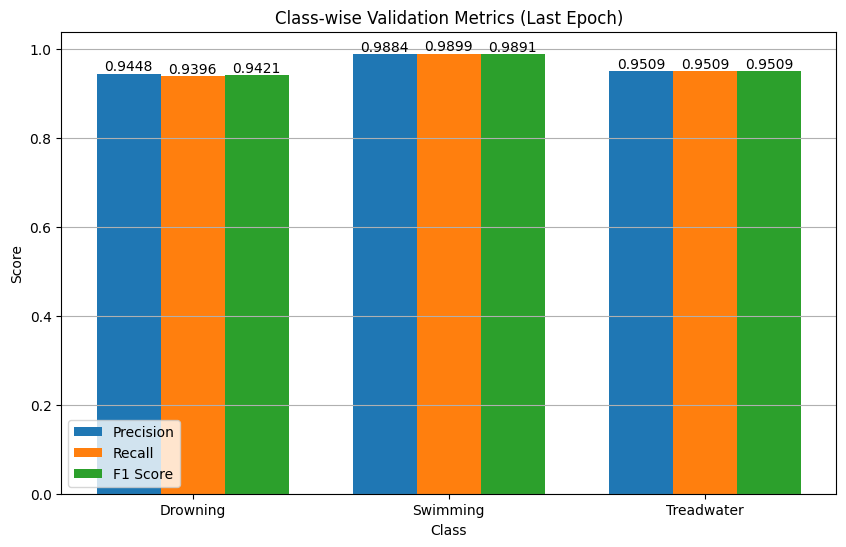

In [23]:
# Validation metrics (final epoch)
final_validation_metric = validation_metrics[-1]

# Extracting precision, recall, f1 for the three classes
classes = ['Drowning', 'Swimming', 'Treadwater']
precision = [final_validation_metric['drowning']['precision'],
             final_validation_metric['swimming']['precision'],
             final_validation_metric['treadwater']['precision']]

recall = [final_validation_metric['drowning']['recall'],
          final_validation_metric['swimming']['recall'],
          final_validation_metric['treadwater']['recall']]

f1_score = [final_validation_metric['drowning']['f1-score'],
            final_validation_metric['swimming']['f1-score'],
            final_validation_metric['treadwater']['f1-score']]

# Plotting classwise metrics (Precision, Recall, F1-Score)
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
bars_precision = ax.bar(x - width, precision, width, label='Precision')
bars_recall = ax.bar(x, recall, width, label='Recall')
bars_f1 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add values on top of each bar
for bar in bars_precision:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

for bar in bars_recall:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

for bar in bars_f1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Class-wise Validation Metrics (Last Epoch)')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(axis='y')

# Display the plot
plt.show()


In [8]:
model.save(
    os.path.join(os.getenv('CNN_MODEL_DIR'), 'baseline.pt')
)

Model saved to C:\Users\hp\Downloads\Drowning-Detection/models/classification/CNN\baseline.pt


In [9]:
# Add model prediction here
loaded_model = TorchClassifier(model='CNNClassifier', model_path=os.path.join(os.getenv('CNN_MODEL_DIR'), 'baseline.pt'), device='auto', verbose=False)

img = Image.open(rf'C:\Users\hp\Downloads\Drowning-Detection\data\roi\val\drowning\{str(63).zfill(6)}.jpg')

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

prediction = loaded_model(
    img=img,
    transform=val_transform,
    prob=True
).cpu().numpy()

IDX_TO_CLASS2 = {
    0: 'drowning',
    1: 'swimming',
    2: 'treadwater'
}

print(prediction)
print(IDX_TO_CLASS2[np.argmax(prediction)])

loaded_model_results = loaded_model.validate(
    data_path=os.getenv('ROI_DATA_DIR'),
    transform=val_transform,
    val_test_ratio=0.5
)

[0.97164255 0.00869891 0.01965857]
drowning


Validation: 100%|██████████| 37/37 [00:22<00:00,  1.61it/s]

              precision    recall  f1-score   support

    drowning     0.9519    0.9780    0.9648       182
    swimming     0.9956    0.9928    0.9942       690
  treadwater     0.9681    0.9579    0.9630       285

    accuracy                         0.9818      1157
   macro avg     0.9719    0.9762    0.9740      1157
weighted avg     0.9820    0.9818    0.9819      1157

